## Analysis of Translation Efficiencies

### 1 Data import

In [1]:
import cPickle as pkl
import collections as col
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use("pgf")
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%matplotlib inline
#matplotlib.style.use('ggplot')
matplotlib.style.use('bmh')

pgf_with_rc_fonts = {
    "font.family": "serif",
    "font.serif": [u'Adobe Caslon Pro'],                   # use latex default serif font
    "font.sans-serif": ["Consolas"], # use a specific sans-serif font
}
matplotlib.rcParams.update(pgf_with_rc_fonts)

from statsmodels.nonparametric.smoothers_lowess import lowess

To update the TEs, run https://github.com/gittenberg/TRSL/blob/master/workbooks/analyses/06%20TRSL_time-resolved_single-gene_analyses.ipynb first.

In [2]:
time_tes = pkl.load(open("../../parameters/te_time-resolved.p"))
init_rates = pkl.load(open("../../parameters/init_rates_plotkin.p"))

In [3]:
time_tes.head()

,0,300,600,900,1200,1500,1800,2100,2400,2700,3000,3300
YAL001C,0.026667,0.023333,0.010833,0.015000,0.018333,0.036667,0.040000,NaN,0.036667,0.033333,NaN,0.043333
YAL002W,0.013333,NaN,0.011667,0.008333,0.006667,0.015000,0.013333,0.026667,0.005000,0.021667,NaN,0.013333
YAL003W,0.142579,0.143810,0.098534,0.098801,0.104697,0.198377,0.197895,0.201111,0.202593,0.202376,0.242971,0.192971
YAL005C,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
YAL007C,0.054167,0.061111,0.033788,0.038889,0.038333,0.094444,0.097778,0.088333,0.100833,0.098333,0.131667,0.076111


In [4]:
annotations = pd.DataFrame.from_csv('../../data/sce_Nagaraj.tsv', sep='\t', header=1)

How many can we work with:

In [5]:
print time_tes.shape
print len(init_rates.keys())
print len(annotations.index)
print len(time_tes.transpose().to_dict().viewkeys() & init_rates.viewkeys())

(5575, 12)
4839
3794
4605


### 2 Translation efficiencies vs initiation rates over the cycle

In [6]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [7]:
def scatter_dicts(dict1, dict2, lowess=True, logaxis=True, xaxislabel=None, yaxislabel=None, fontsize=None, alpha=0.2):
    plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
    print len(plotkeys)
    xs = [dict1[key] for key in plotkeys]
    ys = [dict2[key] for key in plotkeys] 

    fig =  plt.figure()                

    ax = fig.add_subplot(111)
    ax.grid(True, linestyle = '-', color = '0.75')
    if logaxis:
        ax.set_xscale('log')
        ax.set_yscale('log')
    if xaxislabel:
        ax.set_xlabel(xaxislabel)
        if fontsize:
            ax.set_xlabel(xaxislabel, fontsize=fontsize)
    if yaxislabel:
        ax.set_ylabel(yaxislabel)
        if fontsize:
            ax.set_ylabel(yaxislabel, fontsize=fontsize)
    if fontsize:
        plt.setp(ax.get_xticklabels(), fontsize=fontsize)
        plt.setp(ax.get_yticklabels(), fontsize=fontsize)

    scat = plt.scatter(xs, ys)
    scat.set_alpha(alpha)

    if lowess:
        points = zip(xs, ys)
        sorted_points = sorted(points)
        new_xs = [point[0] for point in sorted_points]
        new_ys = [point[1] for point in sorted_points]
        ylowess = lowess(new_ys, new_xs)[:,1]
        plt.plot(new_xs, ylowess, 'orange', linewidth=4)

4605


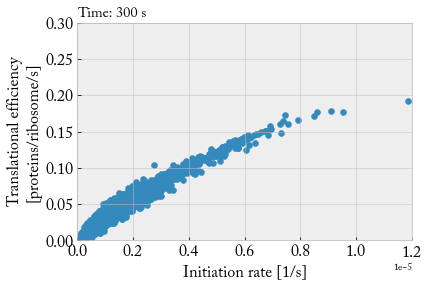

4605


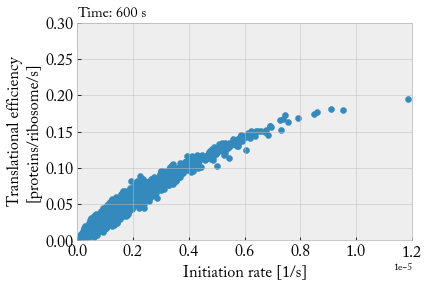

4605


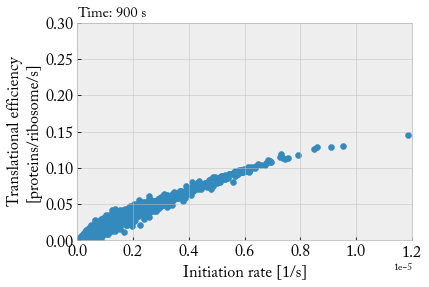

4605


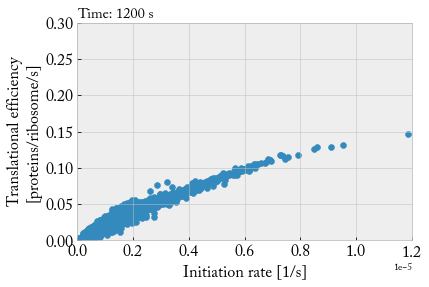

4605


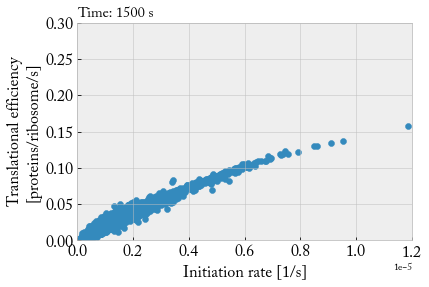

4605


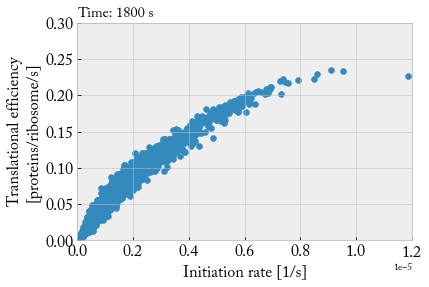

4605


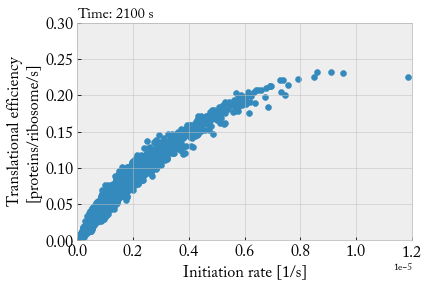

4605


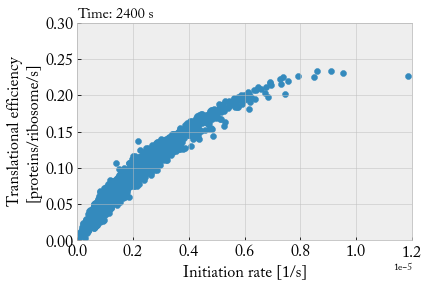

4605


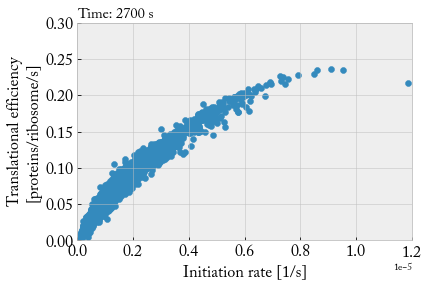

4605


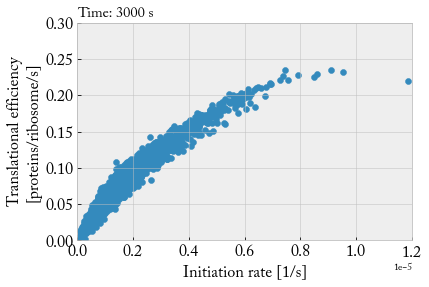

4605


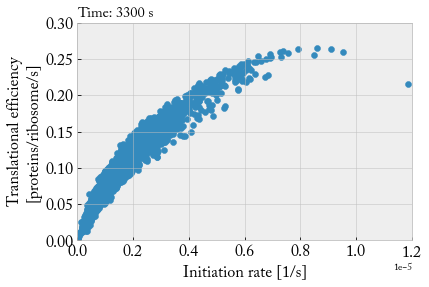

4605


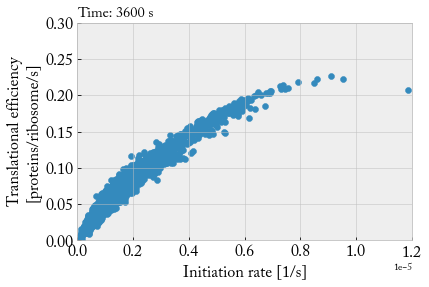

In [10]:
for time in time_tes.columns:
    scatter_dicts(init_rates, time_tes[time].to_dict(), logaxis=False, lowess=False, xaxislabel='Initiation rate [1/s]', 
                  yaxislabel='Translational efficiency\n[proteins/ribosome/s]', fontsize=16, alpha=1.0)
    plt.title('Time: {} s'.format(time+300), loc='left')
    plt.xlim([1e-8, 1.2e-5])
    plt.ylim([0.0, 0.3])
    plt.locator_params(axis='x',nbins=10)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.show()

### 3 Same but with annotation and color

In [11]:
mincount = 50

In [12]:
all_annotations = pkl.load(open("../../parameters/annotations_liebermeister.p", "rb"))
annotations = {k: v for k, v in all_annotations.items() if v}  # remove empty values
all_functional_categories = col.Counter(annotations.values())
functional_categories = col.Counter({k: v for k, v in all_functional_categories.items() if v >= mincount})
annotations = {k: v for k, v in annotations.items() if v in functional_categories}

In [13]:
categories_used = len(functional_categories)
functional_categories

Counter({'Amino acid metabolism': 119,
         'Chaperones and folding catalysts': 63,
         'Chromosome-related': 113,
         'Cofactor biosynthesis': 82,
         'Glycolysis': 54,
         'Lipid and steroid metabolism': 67,
         'Other enzymes': 124,
         'Ribosome': 110,
         'Ribosome biogenesis in eukaryotes': 55,
         'Spliceosome': 54})

Comparing all annotations with those that have the minimum count:

In [14]:
# intersection
anno_keys = init_rates.viewkeys() & time_tes.transpose().to_dict().viewkeys() & all_annotations.viewkeys()
print len(anno_keys)

3472


In [15]:
plotkeys = init_rates.viewkeys() & time_tes.transpose().to_dict().viewkeys() & annotations.viewkeys() # intersection
print len(plotkeys)

725


In [16]:
time_tes_by_function = {}
init_rates_by_function = {}

for time in time_tes.columns:
    time_tes_by_function[time] = {}

    for function in functional_categories.keys():
        init_rates_by_function[function] = [init_rates[key] for key in plotkeys if annotations[key]==function]
        time_tes_by_function[time][function] = [time_tes[time].to_dict()[key] for key in plotkeys 
                                                if annotations[key]==function]

#### Checking and sorting the means

In [17]:
import operator
sorted_functions = sorted({function: np.nanmean(time_tes_by_function[300][function]) 
                           for function in time_tes_by_function[300]}.items(), 
                           key=operator.itemgetter(1),
                           reverse=True)
sorted_functions

[('Ribosome', 0.12347853664006646),
 ('Glycolysis', 0.08240811388488108),
 ('Chaperones and folding catalysts', 0.06883933492560936),
 ('Amino acid metabolism', 0.06100709608344855),
 ('Ribosome biogenesis in eukaryotes', 0.05363906469045359),
 ('Lipid and steroid metabolism', 0.050389449311934384),
 ('Other enzymes', 0.049375855737671406),
 ('Spliceosome', 0.04907013658176449),
 ('Cofactor biosynthesis', 0.047231588255929956),
 ('Chromosome-related', 0.0391216537151836)]

Looks good.

#### Plotting

We assign colors to the functions:

In [18]:
colordict = {function[0]: cm.Paired(i) for i, function in enumerate(sorted_functions)}

The last 2 look ugly and are replaced manually:

In [19]:
#colordict['Glycan metabolism'] = (0.4, 0.4, 0.4, 1.0)
#colordict['Chromosome-related'] = (1.0, 1.0, 1.0, 0.0)

Some manual adjustments:

In [20]:
colordict['Ribosome'], colordict['Lipid and steroid metabolism'] = \
colordict['Lipid and steroid metabolism'], colordict['Ribosome']

#colordict['Glycan metabolism'], colordict['Chaperones and folding catalysts'] = \
#colordict['Chaperones and folding catalysts'], colordict['Glycan metabolism']

In [21]:
colordict

{'Amino acid metabolism': (0.2, 0.6274509803921569, 0.17254901960784313, 1.0),
 'Chaperones and folding catalysts': (0.6980392156862745,
  0.8745098039215686,
  0.5411764705882353,
  1.0),
 'Chromosome-related': (0.41568627450980394,
  0.23921568627450981,
  0.6039215686274509,
  1.0),
 'Cofactor biosynthesis': (0.792156862745098,
  0.6980392156862745,
  0.8392156862745098,
  1.0),
 'Glycolysis': (0.12156862745098039,
  0.47058823529411764,
  0.7058823529411765,
  1.0),
 'Lipid and steroid metabolism': (0.6509803921568628,
  0.807843137254902,
  0.8901960784313725,
  1.0),
 'Other enzymes': (0.9921568627450981,
  0.7490196078431373,
  0.43529411764705883,
  1.0),
 'Ribosome': (0.8901960784313725,
  0.10196078431372549,
  0.10980392156862745,
  1.0),
 'Ribosome biogenesis in eukaryotes': (0.984313725490196,
  0.6039215686274509,
  0.6,
  1.0),
 'Spliceosome': (1.0, 0.4980392156862745, 0.0, 1.0)}

We create several series and scatter on top of each other.

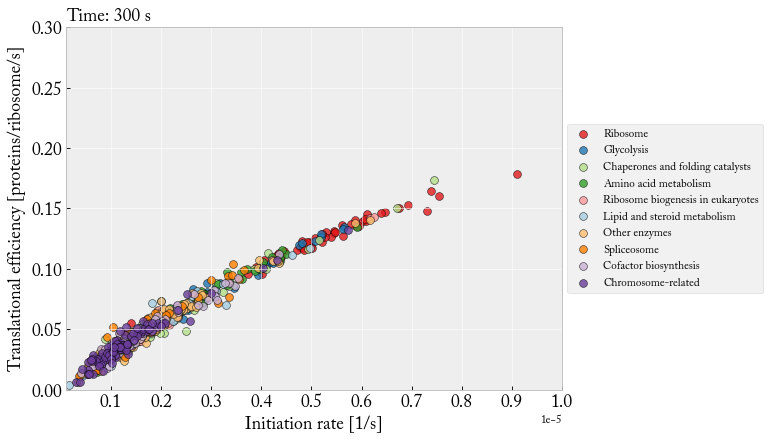

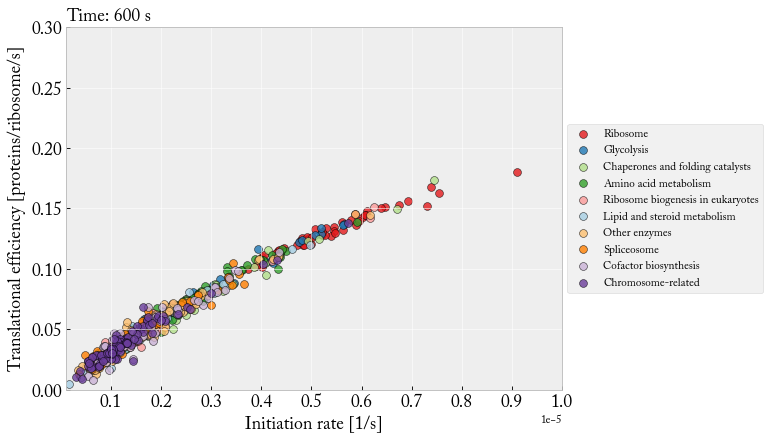

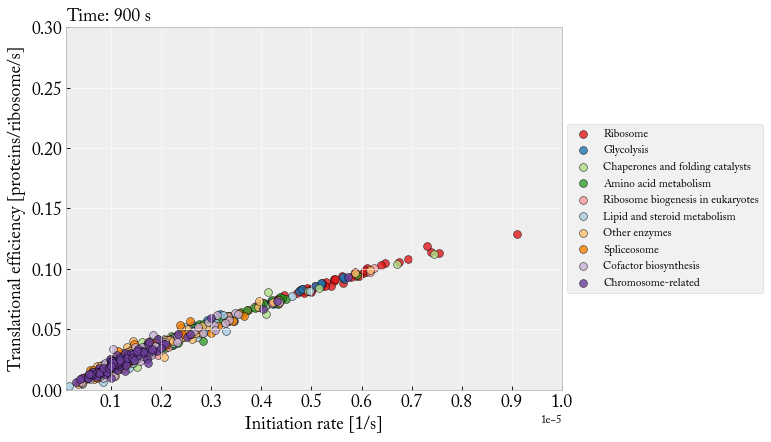

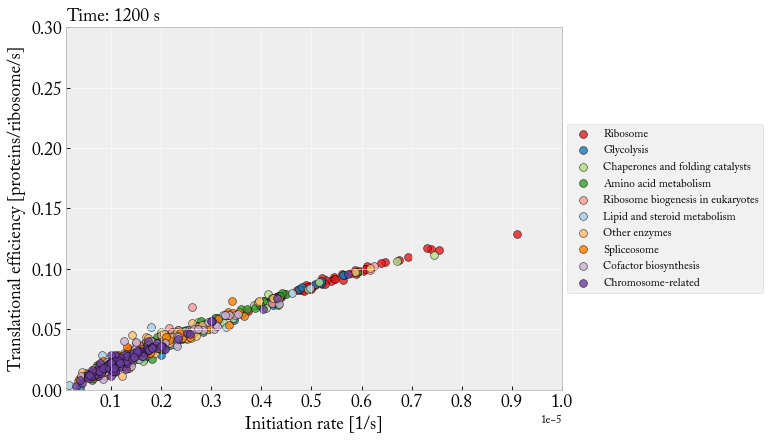

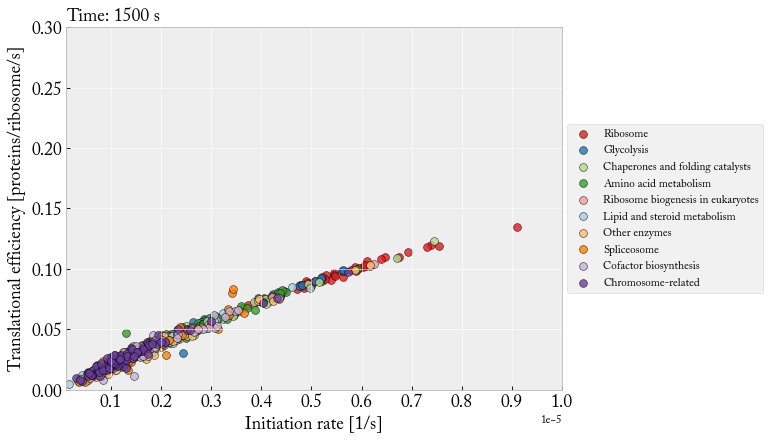

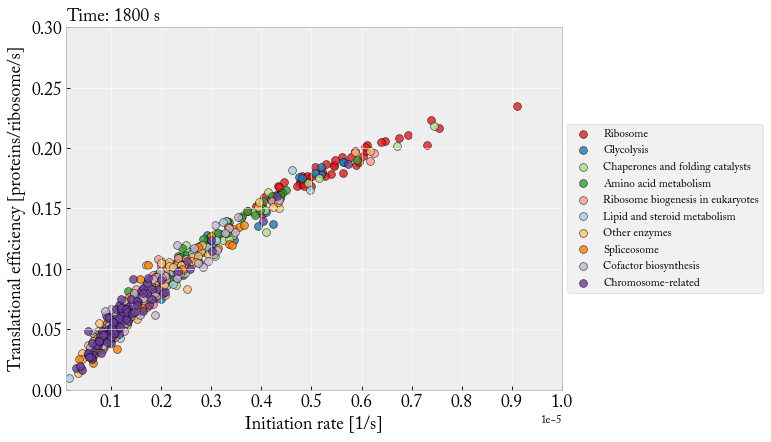

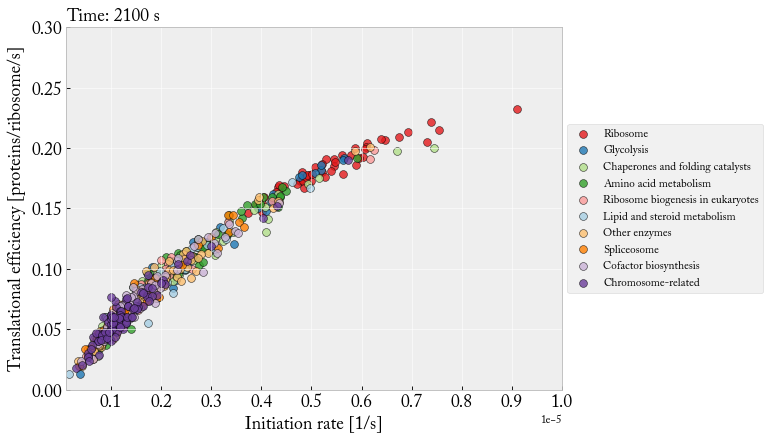

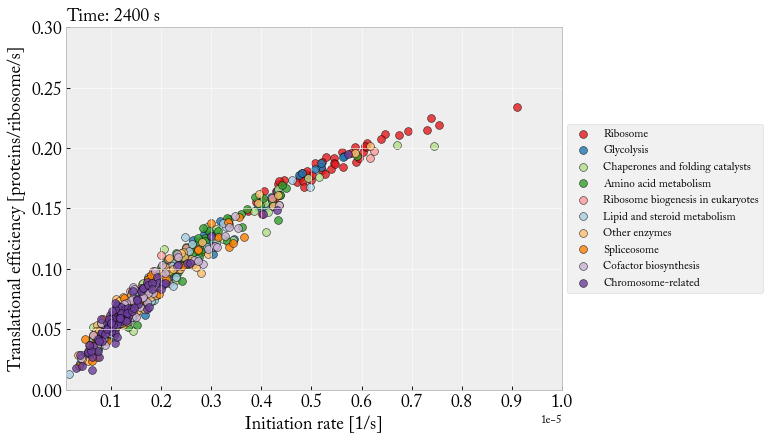

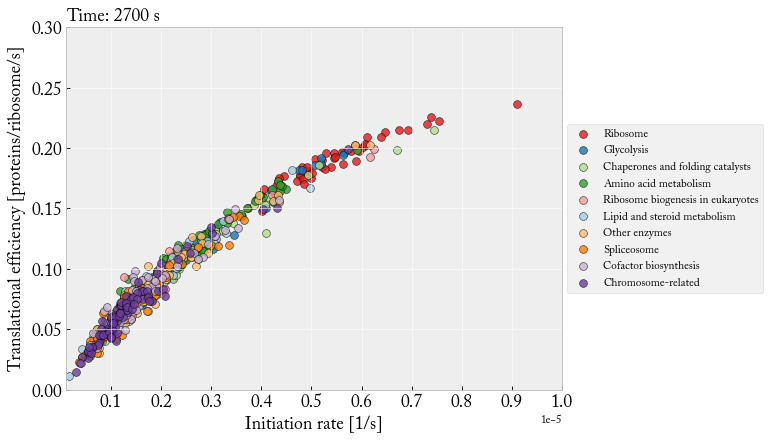

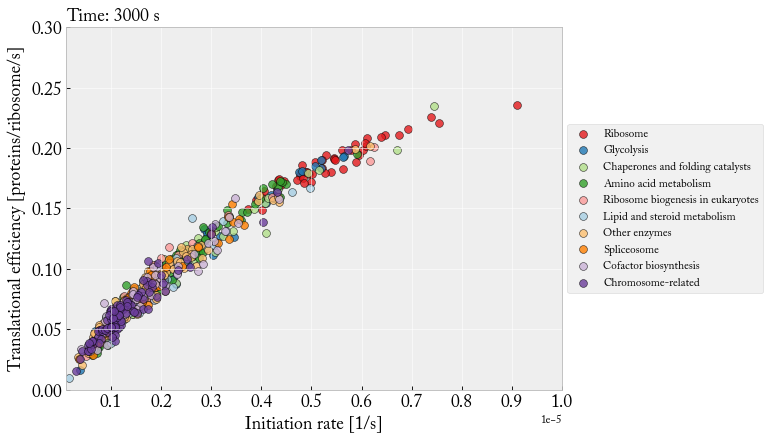

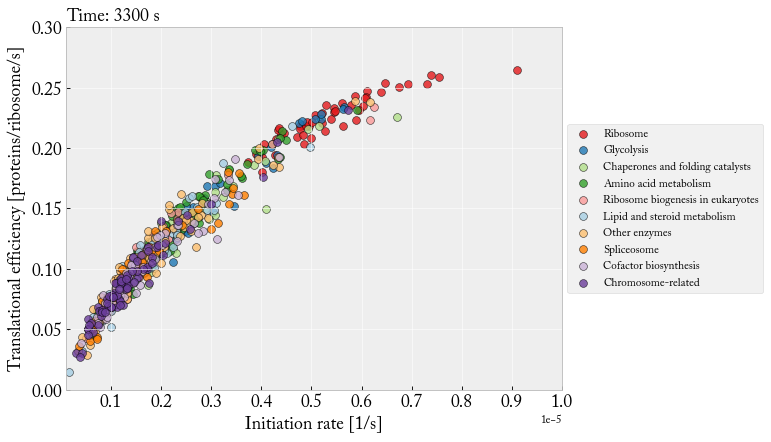

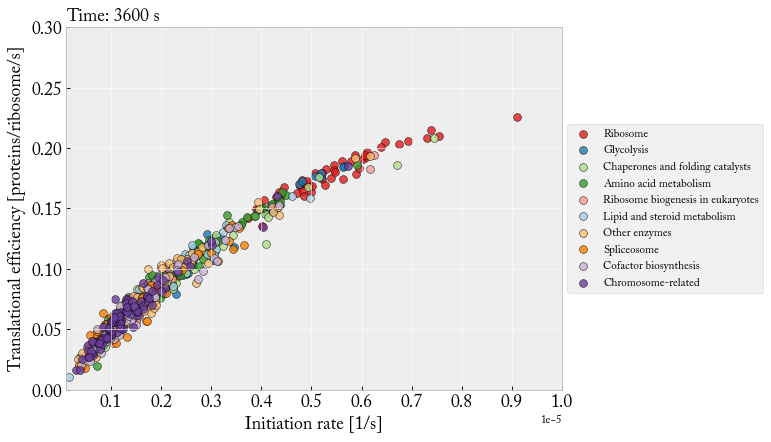

In [22]:
fontsize = 16

xaxislabel = 'Initiation rate [1/s]'
yaxislabel = 'Translational efficiency [proteins/ribosome/s]'

for time in time_tes.columns:
    fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w')                

    ax = fig.add_subplot(111)
    ax.grid(True, linestyle = '-', color = '1.0')

    for function, _ in sorted_functions:
        scat = plt.scatter(init_rates_by_function[function], time_tes_by_function[time][function], 
                           c=colordict[function],
                           label=function, 
                           s=50, 
                           edgecolor='black')
        scat.set_alpha(0.8)

    plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
    plt.xlim([1e-7, 1.0e-5])
    plt.ylim([0.0, 0.3])
    plt.locator_params(axis='x',nbins=10)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True)

    #ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.set_xlabel(xaxislabel)
    ax.set_xlabel(xaxislabel, fontsize=fontsize)
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    ax.set_ylabel(yaxislabel)
    ax.set_ylabel(yaxislabel, fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

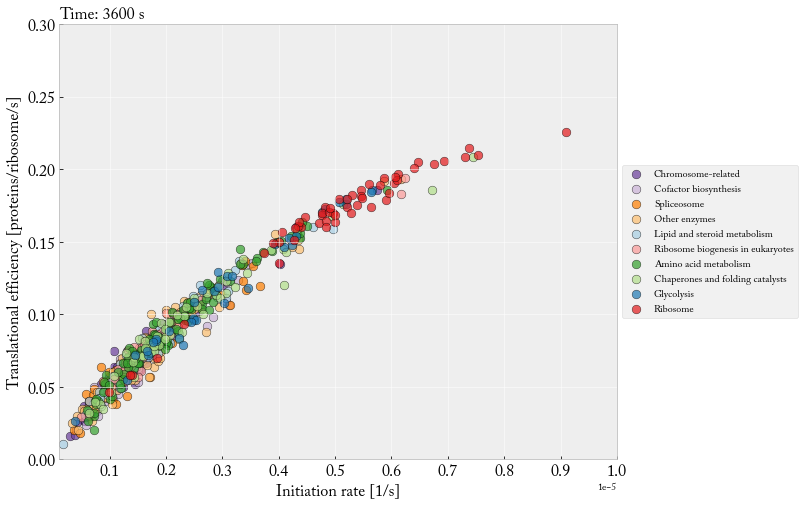

In [23]:
plt.rcParams['figure.figsize'] = (10, 8)

fontsize = 16
xaxislabel = 'Initiation rate [1/s]'
yaxislabel = 'Translational efficiency [proteins/ribosome/s]'

fig =  plt.figure()                

ax = fig.add_subplot(111)
ax.grid(True, linestyle = '-', color = '1.0')

for function, _ in sorted_functions[::-1]:
    scat = plt.scatter(init_rates_by_function[function], time_tes_by_function[time][function], 
                       c=colordict[function],
                       label=function, 
                       s=75, 
                       edgecolor='black')
    scat.set_alpha(0.7)
    
plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
plt.xlim([1e-7, 1.0e-5])
plt.ylim([0.0, 0.3])
plt.locator_params(axis='x',nbins=10)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True)

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)

### Plot against time axis

In [24]:
annotations_df = pd.DataFrame.from_dict(annotations, orient='index', dtype=None)
annotations_df.columns = ["Function"]

In [25]:
time_tes_annotated = pd.merge(time_tes, annotations_df, how='inner', on=None, left_on=None, right_on=None,
                              left_index=True, right_index=True, sort=True, copy=True, indicator=False)

In [26]:
time_tes_annotated.head()

,0,300,600,900,1200,1500,1800,2100,2400,2700,3000,3300,Function
YAL012W,0.112587,0.114672,0.075221,0.078857,0.080982,0.165161,0.164095,0.167304,0.165707,0.170325,0.206296,0.161124,Amino acid metabolism
YDR050C,0.134776,0.137036,0.091983,0.094864,0.098355,0.188675,0.191795,0.193188,0.195629,0.193301,0.233997,0.185446,Glycolysis
YMR288W,0.035000,0.029167,0.024167,0.021667,0.020000,0.033333,0.048333,0.063333,0.061667,NaN,0.071667,0.061667,Spliceosome
YLR197W,0.069265,0.069524,0.044400,0.043673,0.046995,0.104420,0.103417,0.102754,0.105494,0.106726,0.141563,0.102957,Ribosome biogenesis in eukaryotes
YBR167C,0.053333,NaN,0.039444,0.051111,0.040833,0.100000,0.095000,0.088333,0.115000,0.118333,NaN,0.100000,Ribosome biogenesis in eukaryotes


In [27]:
print len(time_tes_annotated)
print len(time_tes)
print len(annotations_df)

828
5575
841


Same for the larger set:

In [28]:
all_annotations_df = pd.DataFrame.from_dict(all_annotations, orient='index', dtype=None)
all_annotations_df.columns = ["Function"]

In [29]:
all_time_tes_annotated = pd.merge(time_tes, all_annotations_df, how='inner', on=None, left_on=None, right_on=None,
                              left_index=True, right_index=True, sort=True, copy=True, indicator=False)

In [30]:
all_time_tes_annotated.head()

,0,300,600,900,1200,1500,1800,2100,2400,2700,3000,3300,Function
YBR177C,0.048889,0.047500,NaN,0.034444,0.038333,0.091667,0.070000,0.095000,0.091667,0.081667,0.133333,0.083333,
YIL140W,0.045833,0.045000,0.037917,0.031667,0.028333,0.068333,NaN,NaN,0.070000,NaN,NaN,NaN,
YLR268W,0.051667,0.052667,0.032963,0.034167,0.036875,0.076667,0.075417,0.089444,0.093333,0.086111,0.115000,0.084444,SNARE interactions in vesicular transport
YJL155C,0.047500,0.046667,0.038333,0.016667,0.044167,NaN,0.076667,NaN,0.078333,0.068333,0.096667,0.066667,Carbohydrate metabolism
YLR197W,0.069265,0.069524,0.044400,0.043673,0.046995,0.104420,0.103417,0.102754,0.105494,0.106726,0.141563,0.102957,Ribosome biogenesis in eukaryotes


In [31]:
print len(all_time_tes_annotated)
print len(time_tes)
print len(all_annotations_df)

3732
5575
3794


#### Dynamic range

In [32]:
time_tes.max(axis=0, skipna=None, level=None, numeric_only=None)

0       0.192222
300     0.194444
600     0.145833
900     0.146667
1200    0.158333
1500    0.234781
1800    0.232593
2100    0.234028
2400    0.236351
2700    0.235631
3000    0.265000
3300    0.226014
dtype: float64

In [33]:
time_tes.min(axis=0, skipna=True, level=None, numeric_only=True)

0       0.0
300     0.0
600     0.0
900     0.0
1200    0.0
1500    0.0
1800    0.0
2100    0.0
2400    0.0
2700    0.0
3000    0.0
3300    0.0
dtype: float64

In [34]:
all_time_tes_annotated.min(axis=0, skipna=True, level=None, numeric_only=True)

0       0.0
300     0.0
600     0.0
900     0.0
1200    0.0
1500    0.0
1800    0.0
2100    0.0
2400    0.0
2700    0.0
3000    0.0
3300    0.0
dtype: float64

Does not work because of zeros.

#### Plot by function with jitter:

http://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints-in-a-scatter-dot-beeswarm-plot

In [35]:
def rand_jitter(arr):
    stdev = .0125 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, 
           linewidths=None, verts=None, hold=None, **kwargs):
    return plt.scatter(rand_jitter(x), y, s=s, c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, 
                       vmax=vmax, alpha=alpha, linewidths=linewidths, verts=verts, hold=hold, **kwargs)

/home/martin/.local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


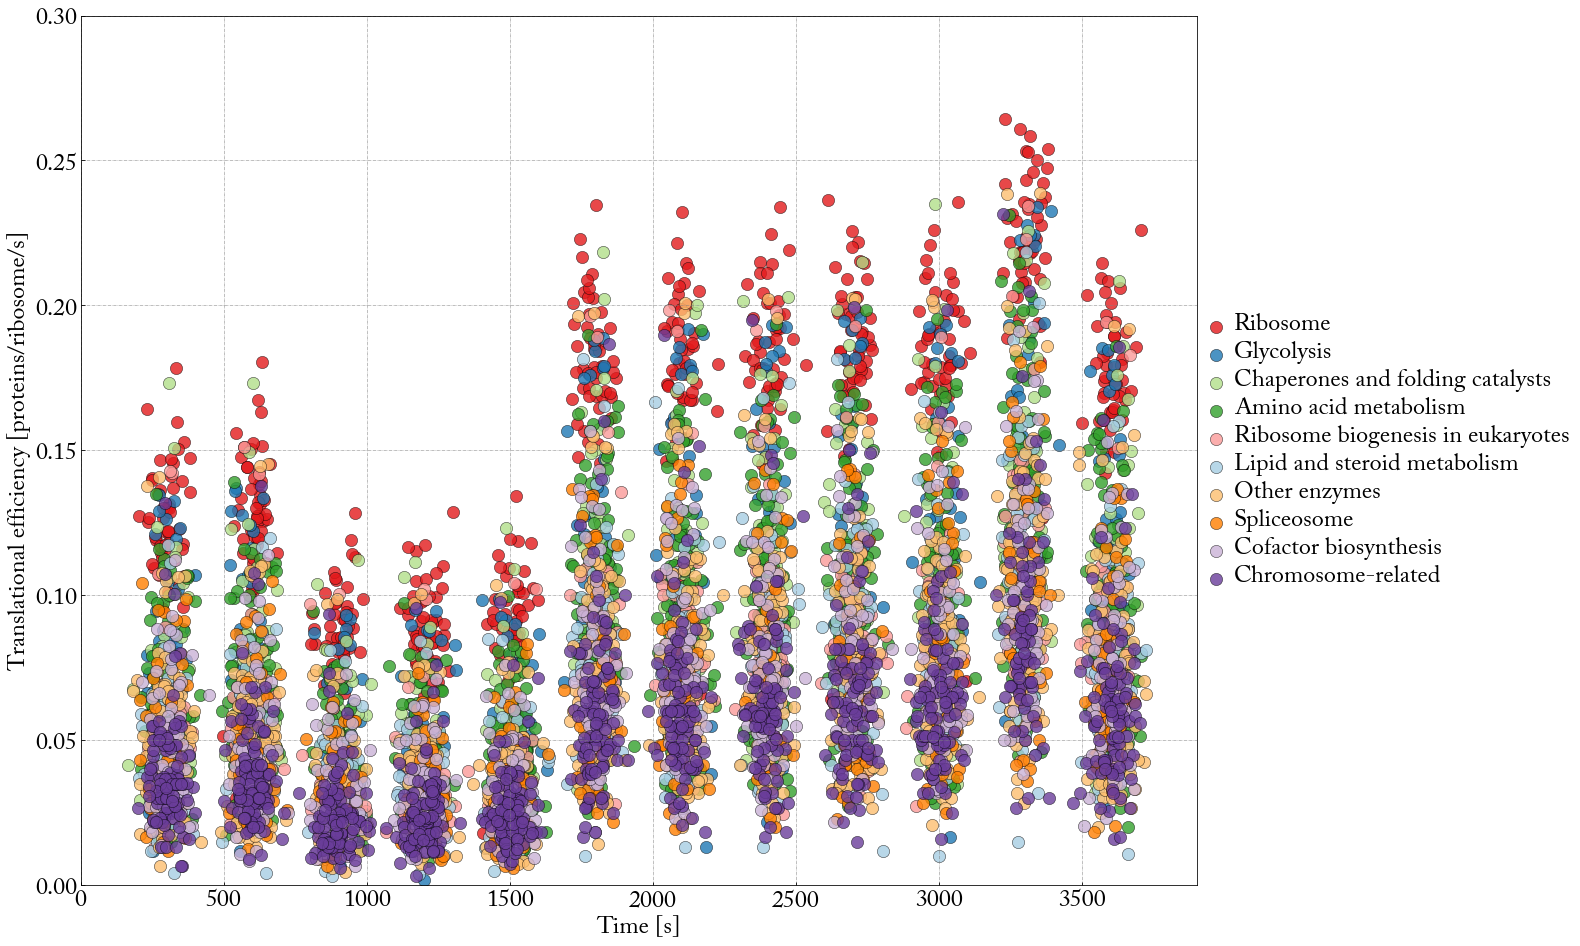

In [36]:
plt.rc('font',family=u'Adobe Caslon Pro')
plt.rcParams['figure.figsize'] = (20, 16)
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['axes.labelcolor']='black'
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.rcParams['grid.linestyle']='-.'
plt.rcParams['grid.color']='grey'
#plt.rcParams['figure.facecolor'] = 'white'

hfont = {'fontname': u'Adobe Caslon Pro'}

fig =  plt.figure()                

ax = fig.add_subplot(111, axisbg='white')

fontsize = 24

xaxislabel = 'Time [s]'
yaxislabel = 'Translational efficiency [proteins/ribosome/s]'

#plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
plt.xlim([0, 3900])
plt.ylim([0.0, 0.3])
#plt.locator_params(axis='x',nbins=10)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_xlabel(xaxislabel, **hfont)
ax.set_xlabel(xaxislabel, fontsize=fontsize, **hfont)
plt.setp(ax.get_xticklabels(), fontsize=fontsize, **hfont)
#ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize, **hfont)
plt.setp(ax.get_yticklabels(), fontsize=fontsize, **hfont)

for function, _ in sorted_functions:
    df = time_tes_annotated[time_tes_annotated['Function']==function]
    del df['Function']
    df = df[df!=0]  # not sure why but after updating there were many zero values. I remove them manually
    df = df.transpose()
    for i, gene in enumerate(df.columns):
        scat = jitter(df.index+300, df[gene], c=colordict[function], label=function, s=150, edgecolor='black')
        scat.set_alpha(0.8)      

handles, labels = ax.get_legend_handles_labels()
#print handles
#print labels

# sort labels
labels_tmp = [u'Glycolysis', u'Chaperones and folding catalysts',
       u'Amino acid metabolism', u'Ribosome',
       u'Ribosome biogenesis in eukaryotes', u'Lipid and steroid metabolism',
       u'Other enzymes', u'Spliceosome', u'Cofactor biosynthesis',
       u'Chromosome-related']
# sort handles the same way
# https://stackoverflow.com/questions/6618515/sorting-list-based-on-values-from-another-list
handles_tmp = [x for _, x in sorted(zip(labels_tmp, handles))]


#shortlabels = list(set(labels))
#print shortlabels

plt.legend(handles_tmp, labels_tmp, loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, facecolor="white", frameon=False)

legend = ax.get_legend()

for i, label in enumerate(sorted_functions):
    legend.legendHandles[i].set_color(colordict[label[0]])
    #legend.legendHandles[i].set_color(colors[i])
    legend.legendHandles[i].set_edgecolor('black')
    legend.get_texts()[i].set_text(label[0])
    legend.get_texts()[i].set_fontsize(fontsize)

#plt.legend(frameon=False)
#for label in legend.get_texts():
#    label.set_fontsize(fontsize)
    
plt.savefig("time_resolved_efficiency.png", bbox_inches='tight')
plt.show()

### Combined in one plot

In [ ]:
plt.rcParams['figure.figsize'] = (10, 15)

fig =  plt.figure()                

ax = fig.add_subplot(211, axisbg='white')

fontsize = 18
markersize = 60

xaxislabel = 'Time [s]'
yaxislabel = 'Translational efficiency\n[proteins/ribosome/s]'

ax.grid(True, linestyle = '-.', color = 'grey')

#plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
plt.xlim([0, 3900])
plt.ylim([0.0, 0.3])
#plt.locator_params(axis='x',nbins=10)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)

for function, _ in sorted_functions:
    df = time_tes_annotated[time_tes_annotated['Function']==function]
    del df['Function']
    df = df[df!=0]  # not sure why but after updating there were many zero values. I remove them manually
    df = df.transpose()
    for i, gene in enumerate(df.columns):
        scat = jitter(df.index+300, df[gene], c=colordict[function], label=function, s=markersize, edgecolor='black',
                     rasterized=True)
        scat.set_alpha(1.0)      

handles, labels = ax.get_legend_handles_labels()
#print handles
#print labels

shortlabels = list(set(labels))

#plt.text(-350, 0.3, "A", fontsize=24, weight="bold")

ax = fig.add_subplot(212, axisbg='white')

time = 300
#fontsize = 24
xaxislabel = 'Initiation rate [1/s]'
yaxislabel = 'Translational efficiency\n[proteins/ribosome/s]'

ax.grid(True, linestyle = '-.', color = 'grey')

for function, _ in sorted_functions:
    scat = plt.scatter(init_rates_by_function[function], time_tes_by_function[time][function], 
                       c=colordict[function],
                       label=function, 
                       s=75, 
                       edgecolor='black')
    scat.set_alpha(1.0)
    
#plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
ax.text(.05, .92, 'Time: 600 s', horizontalalignment='left', transform=ax.transAxes, fontsize=15)

plt.xlim([1e-7, 1.0e-5])
plt.ylim([0.0, 0.3])
plt.locator_params(axis='x',nbins=10)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), fontsize=fontsize)
plt.rc('font', **{'size':'24'})

#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, fontsize=fontsize)
legend = plt.legend(fancybox=True, fontsize=fontsize, bbox_to_anchor=(1.0, 0.9), frameon=False)
legend.get_frame().set_facecolor('white')

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)

#plt.text(-0.08e-5, 0.3, "B", fontsize=24, weight="bold")

plt.savefig('time_and_init_rate_resolved_efficiency.png', bbox_inches='tight', dpi=400)
#plt.savefig('time_and_init_rate_resolved_efficiency.pdf', bbox_inches='tight', dpi=400)
#plt.savefig('time_and_init_rate_resolved_efficiency.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)

fig =  plt.figure()                

ax = fig.add_subplot(111, axisbg='white')

fontsize = 18
markersize = 60

time = 300
#fontsize = 24
xaxislabel = 'Initiation rate [1/s]'
yaxislabel = 'Translational efficiency\n[proteins/ribosome/s]'

ax.grid(True, linestyle = '-.', color = 'grey')

for function in functional_categories.keys():
    scat = plt.scatter(init_rates_by_function[function], time_tes_by_function[time][function], c=colordict[function], 
                       label=function, s=markersize, edgecolor='black', rasterized=True)
    scat.set_alpha(0.8)
    
#plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
ax.text(.05, .92, 'Time: 600 s', horizontalalignment='left', transform=ax.transAxes, fontsize=15)

plt.xlim([1e-7, 1.0e-5])
plt.ylim([0.0, 0.3])
plt.locator_params(axis='x',nbins=10)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), fontsize=fontsize)
plt.rc('font', **{'size':'24'})

#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, fontsize=fontsize)
legend = plt.legend(fancybox=True, fontsize=fontsize, bbox_to_anchor=(1.0, 0.9), frameon=False)
legend.get_frame().set_facecolor('white')

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)

#plt.text(-0.08e-5, 0.3, "B", fontsize=24, weight="bold")

plt.savefig('efficiency_by_function_and_init_rate.png', bbox_inches='tight', dpi=400)
#plt.show()

For Computer Modern:

In [ ]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.rcParams['figure.figsize'] = (10, 15)

fig =  plt.figure()                

ax = fig.add_subplot(211, axisbg='white')

fontsize = 18
markersize = 60

xaxislabel = 'Time [s]'
yaxislabel = 'Translational efficiency\n[proteins/ribosome/s]'

ax.grid(True, linestyle = '-.', color = 'grey')

#plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
plt.xlim([0, 3900])
plt.ylim([0.0, 0.3])
#plt.locator_params(axis='x',nbins=10)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)

for function, _ in sorted_functions:
    df = time_tes_annotated[time_tes_annotated['Function']==function]
    del df['Function']
    df = df[df!=0]  # not sure why but after updating there were many zero values. I remove them manually
    df = df.transpose()
    for i, gene in enumerate(df.columns):
        scat = jitter(df.index+300, df[gene], c=colordict[function], label=function, s=markersize, edgecolor='black',
                     rasterized=True)
        scat.set_alpha(1.0)      

handles, labels = ax.get_legend_handles_labels()
#print handles
#print labels

shortlabels = list(set(labels))

#plt.text(-350, 0.3, "A", fontsize=24, weight="bold")

ax = fig.add_subplot(212, axisbg='white')

time = 300
#fontsize = 24
xaxislabel = 'Initiation rate [1/s]'
yaxislabel = 'Translational efficiency\n[proteins/ribosome/s]'

ax.grid(True, linestyle = '-.', color = 'grey')

for function, _ in sorted_functions:
    scat = plt.scatter(init_rates_by_function[function], time_tes_by_function[time][function], 
                       c=colordict[function],
                       label=function, 
                       s=75, 
                       edgecolor='black')
    scat.set_alpha(1.0)
    
#plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
ax.text(.05, .92, 'Time: 600 s', horizontalalignment='left', transform=ax.transAxes, fontsize=15)

plt.xlim([1e-7, 1.0e-5])
plt.ylim([0.0, 0.3])
plt.locator_params(axis='x',nbins=10)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), fontsize=fontsize)
plt.rc('font', **{'size':'24'})

#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, fontsize=fontsize)
legend = plt.legend(fancybox=True, fontsize=fontsize, bbox_to_anchor=(1.0, 0.9), frameon=False)
legend.get_frame().set_facecolor('white')

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)

#plt.text(-0.08e-5, 0.3, "B", fontsize=24, weight="bold")

plt.savefig('time_and_init_rate_resolved_efficiency.png', bbox_inches='tight', dpi=400)
#plt.savefig('time_and_init_rate_resolved_efficiency.pdf', bbox_inches='tight', dpi=400)
#plt.savefig('time_and_init_rate_resolved_efficiency.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

#### Separate plots

Trick to make labels unique: https://stackoverflow.com/questions/19385639/duplicate-items-in-legend-in-matplotlib

In [ ]:
plt.rcParams['figure.figsize'] = (10, 7.5)

fig =  plt.figure()                

ax = fig.add_subplot(111, axisbg='white')

fontsize = 18
markersize = 60

xaxislabel = 'Time [s]'
yaxislabel = 'Translational efficiency\n[proteins/ribosome/s]'

ax.grid(True, linestyle = '-.', color = 'grey')

#plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
plt.xlim([0, 3900])
plt.ylim([0.0, 0.3])
#plt.locator_params(axis='x',nbins=10)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)

for function in functional_categories.keys():
    df = time_tes_annotated[time_tes_annotated['Function']==function]
    del df['Function']
    df = df[df!=0]  # not sure why but after updating there were many zero values. I remove them manually
    df = df.transpose()
    for i, gene in enumerate(df.columns):
        scat = jitter(df.index+300, df[gene], c=colordict[function], label=function if i == 0 else "", 
                      s=markersize, edgecolor='black', rasterized=True)
        scat.set_alpha(1.0)      

handles, labels = ax.get_legend_handles_labels()
#print handles
#print labels

#labels = list(set(labels))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, fontsize=fontsize)
legend = plt.legend(fancybox=True, fontsize=fontsize, bbox_to_anchor=(1.0, 0.9), frameon=False)
legend.get_frame().set_facecolor('white')


#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)

#plt.text(-0.08e-5, 0.3, "B", fontsize=24, weight="bold")

plt.savefig('time_resolved_efficiency.png', bbox_inches='tight', dpi=400)
#plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = (10, 7.5)

fig =  plt.figure()                

ax = fig.add_subplot(111, axisbg='white')

fontsize = 18
markersize = 60

time = 300
#fontsize = 24
xaxislabel = 'Initiation rate [1/s]'
yaxislabel = 'Translational efficiency\n[proteins/ribosome/s]'

ax.grid(True, linestyle = '-.', color = 'grey')

for function in functional_categories.keys():
    scat = plt.scatter(init_rates_by_function[function], time_tes_by_function[time][function], c=colordict[function], 
                       label=function, s=markersize, edgecolor='black', rasterized=True)
    scat.set_alpha(1.0)
    
#plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
ax.text(.05, .92, 'Time: 600 s', horizontalalignment='left', transform=ax.transAxes, fontsize=15)

plt.xlim([1e-7, 1.0e-5])
plt.ylim([0.0, 0.3])
plt.locator_params(axis='x',nbins=10)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), fontsize=fontsize)
plt.rc('font', **{'size':'24'})

#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, fontsize=fontsize)
legend = plt.legend(fancybox=True, fontsize=fontsize, bbox_to_anchor=(1.0, 0.9), frameon=False)
legend.get_frame().set_facecolor('white')

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)

#plt.text(-0.08e-5, 0.3, "B", fontsize=24, weight="bold")

plt.savefig('efficiency_by_function_and_init_rate.png', bbox_inches='tight', dpi=400)
#plt.show()

In [ ]:
time_tes_by_function.keys()

In [ ]:
time_tes_by_function[0].keys()

In [ ]:
pkl.dump(time_tes_by_function, open("../../parameters/time_tes_by_function.p", "wb"))

In [ ]:
pkl.dump(all_time_tes_annotated, open("../../parameters/all_time_tes_annotated.df", "wb"))

In [ ]:
all_time_tes_annotated

In [ ]:
functional_counts = all_time_tes_annotated.Function.value_counts(dropna=False)

In [ ]:
functional_counts[functional_counts >= 50].index.drop(u'')

In [ ]:
all_time_tes_annotated[all_time_tes_annotated.Function.isin(functional_counts[functional_counts >= 50]
                .index.drop(u''))].groupby(['Function']).size().reset_index(name='counts').sort_values('counts', ascending=False)